In [2]:
#Load the data from train file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load_mnist_data():
    
    data=pd.read_csv('train.csv', sep=',').as_matrix()
    data.shape
    N = data.shape[0]
    n_train = int((N*70)/100)
    X_train = data[:n_train,1:]
    Y_train = data[:n_train,0]

    X_test = data[n_train:,1:]
    Y_test = data[n_train:,0]

    C = 10
    d = X_train.shape[1]
    return data, N, n_train, X_train, Y_train, X_test, Y_test, C, d

In [3]:
data, N, n_train, X_train, Y_train, X_test, Y_test, C, d = load_mnist_data()

In [4]:
%matplotlib inline

In [5]:
import random
# First implement a gradient checker by filling in the following functions
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-10

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        
        ### YOUR CODE HERE: try modifying x[ix] with h defined above to compute numerical gradients
        ### make sure you call random.setstate(rndstate) before calling f(x) each time, this will make it 
        ### possible to test cost functions with built in randomness later
        
        x[ix] = x[ix]+h
        
        random.setstate(rndstate)
        fx1,grad1 = f(x)
        numgrad = (fx1-fx)/h
        
        x[ix] = x[ix]-h
        
        ### END YOUR CODE

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print( "Gradient check failed.")
            print( "First gradient error found at index %s" % str(ix))
            print( "Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numgrad))
            return
        
        it.iternext() # Step to next dimension

    print( "Gradient check passed!")

In [9]:
def network_forward_backward_pass(X, y, W1, b1, W2, b2, reg = 1e-3):
    N = X.shape[0]
    H = np.dot(X, W1) + b1
    H_relu = np.maximum(H, 0)
    scores = np.dot(H_relu, W2) + b2
    
    if y is None:
        return scores
    
    weights = scores - np.max(scores, axis=1, keepdims=True)
    exp = np.exp(weights)
    prob_matrix = exp/np.sum(exp, axis=1, keepdims=True)
    loss = -np.sum(np.log(prob_matrix[np.arange(N), y.reshape(1,-1)]))
    loss /= N
    loss += 0.5 * reg * (np.sum(W1*W1) + np.sum(W2*W2))
    
    #print(prob_matrix[np.arange(N), y.reshape(1,-1)].shape)
    prob_matrix[np.arange(N), y.reshape(1,-1)] -= 1
    dW2 = H_relu.T.dot(prob_matrix)
    db2 = np.sum(prob_matrix, axis=0)
    dX = prob_matrix.dot(W2.T)
    dH = dX*(H>0)
    dW1 = X.T.dot(dH)
    db1 = np.sum(dH, axis=0)
    
    dW2 /= N
    db2 /= N
    dW1 /= N
    db1 /= N
    
    dW2 += reg * W2
    dW1 += reg * W1
    
    return loss, dW1, db1, dW2, db2

def predict(X, W1, b1, W2, b2):
    return np.argmax(network_forward_backward_pass(X, None, W1, b1, W2, b2), axis=1)

predict(X[1:5], W1, b1, W2, b2)
#network_forward_backward_pass(X[1:5], y[1:5], W1, b1, W2, b2)
#gradcheck_naive(lambda t : network_forward_backward_pass(X[1:5], y[1:5], W1, b1, W2, t), b2)

array([0, 1, 4, 0])

Train Cost: 2.315556	 Val cost 2.315919
Train Cost: 0.488772	 Val cost 0.487256
Train Cost: 0.390508	 Val cost 0.385654
Train Cost: 0.353073	 Val cost 0.344732
Train Cost: 0.320935	 Val cost 0.311123
Train Cost: 0.307649	 Val cost 0.297533
Train Cost: 0.312502	 Val cost 0.299256
Train Cost: 0.291057	 Val cost 0.273614
Train Cost: 0.272406	 Val cost 0.253935
Train Cost: 0.272910	 Val cost 0.249243


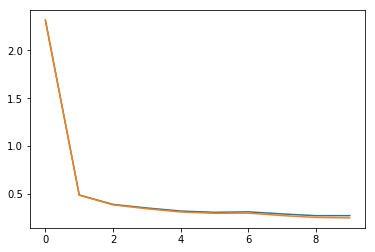

Training Accuracy 0.934116	 Testing Accuracy 0.926270


In [7]:
X = X_train
y = Y_train
X_val = X_test
y_val = Y_test

N = X.shape[0]
D = X.shape[1]
H = 15
C = 10
std = 1e-2
W1 = std*np.random.randn(D, H)
b1 = np.zeros(H)

W2 = std*np.random.randn(H, C)
b2 = np.zeros(C)

def gradient_descent_nn(X, y, X_val, y_val, W1, b1, W2, b2, batch_size = 200, 
                       lr = 1e-3, reg = 0.5e-2, num_iters = 100, print_iters = 10):
    it = 0
    N = X.shape[0]
    stats_train = []
    stats_val = []
    best_val, best_params = -1, None
    while it < num_iters:
        indices = np.random.choice(N, batch_size)
        X_batch = X[indices]
        y_batch = y[indices]
        loss, dW1, db1, dW2, db2 = network_forward_backward_pass(X_batch, y_batch, W1, b1, W2, b2, reg)
        W1 -= lr*dW1
        b1 -= lr*db1
        W2 -= lr*dW2
        b2 -= lr*db2
        
        if it%print_iters == 0:
            #train_acc = np.mean(y == predict(X, W1, b1, W2, b2))
            #val_acc = np.mean(y_val == predict(X_val, W1, b1, W2, b2))
            loss_val = network_forward_backward_pass(X, y, W1, b1, W2, b2, reg)[0]
            loss_train = network_forward_backward_pass(X_val, y_val, W1, b1, W2, b2, reg)[0]
            
            test_accuracy = np.mean(y_val == predict(X_val, W1, b1, W2, b2))
            if test_accuracy > best_val:
                best_val = test_accuracy
                best_params = (W1, b1, W2, b2)
            
            stats_train.append(loss_train)
            stats_val.append(loss_val)
            print("Train Cost: %f\t Val cost %f"%(loss_train, loss_val))
            
        it += 1
    
    return W1, b1, W2, b2, stats_train, stats_val, best_val, best_params

W1, b1, W2, b2, training_error, testing_error, best_val, best_params = gradient_descent_nn(X, y, X_val, y_val, 
                                                                    W1, b1, W2, b2, 
                                                                    num_iters = 1000, print_iters = 100)

x = range(len(training_error))
plt.plot(x, training_error, x, testing_error)
plt.show()

test_accuracy = np.mean(y_val == predict(X_val, W1, b1, W2, b2))
train_accuracy = np.mean(y == predict(X, W1, b1, W2, b2))
print("Training Accuracy %f\t Testing Accuracy %f"%(train_accuracy, test_accuracy))

In [ ]:
def train_with_hyperparameters(H, reg, lr, batch_size):
    
    print("Testing for hidden size : %d, reg : %f, lr : %f, batch_size : %d"%(H, reg, lr, batch_size))
    
    N = X.shape[0]
    D = X.shape[1]
    H = 15
    C = 10
    std = 1e-2
    W1 = std*np.random.randn(D, H)
    b1 = np.zeros(H)

    W2 = std*np.random.randn(H, C)
    b2 = np.zeros(C)

    W1, b1, W2, b2, train_err, testing_err = gradient_descent_nn(X, y, X_val, y_val, W1, b1, W2, b2, 
                                                                 batch_size = batch_size, lr = lr, reg = reg, 
                                                                 num_iters = 1000000, print_iters = 50000)
    
    x = range(len(training_error))
    plt.plot(x, training_error, x, testing_error)
    plt.show()

    test_accuracy = np.mean(y_val == predict(X_val, W1, b1, W2, b2))
    train_accuracy = np.mean(y == predict(X, W1, b1, W2, b2))
    print("Training Accuracy %f\t Testing Accuracy %f"%(train_accuracy, test_accuracy))
    
    params = [W1, b1, W2, b2, H, reg, lr, batch_size]
    return params, train_accuracy, test_accuracy

Hs = {800} #, 10, 15, 20, 25}
regs = {1e-5, 1e-4} #, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1}
lrs = {1e-3}
batches = {200}

best_val = -1
best_params = None

for H in Hs:
    for reg in regs:
        for lr in lrs:
            for batch_size in batches:
                params, train_accuracy, test_accuracy = train_with_hyperparameters(H, reg, lr, batch_size)
                if test_accuracy > best_val:
                    best_val = test_accuracy
                    best_params = params


Testing for hidden size : 800, reg : 0.000010, lr : 0.001000, batch_size : 200
Train Cost: 2.311556	 Val cost 2.312876
Train Cost: 0.444912	 Val cost 0.009691
Train Cost: 0.612937	 Val cost 0.001856
Train Cost: 0.692384	 Val cost 0.000972
Train Cost: 0.743995	 Val cost 0.000652
Train Cost: 0.783001	 Val cost 0.000493
Train Cost: 0.811884	 Val cost 0.000397
Train Cost: 0.837040	 Val cost 0.000335
Train Cost: 0.859262	 Val cost 0.000293
Train Cost: 0.877138	 Val cost 0.000262
Train Cost: 0.893554	 Val cost 0.000238
Train Cost: 0.907907	 Val cost 0.000220
Train Cost: 0.920791	 Val cost 0.000205
Train Cost: 0.932948	 Val cost 0.000193
Train Cost: 0.943899	 Val cost 0.000183


In [ ]:

X_Kaggle=pd.read_csv('test.csv', sep=',').as_matrix()
Y_Kaggle = predict(X_Kaggle, W1, b1, W2, b2)
dataframe = pd.DataFrame({"ImageId":np.arange(28000)+1,"Label":Y_Kaggle})
dataframe.to_csv('submit_nn.csv', index=False)


In [8]:
best_val

0.92277777777777781